# ALONE TV SHOW
## Why we chose this project?
Alone is s survival TV series where 10 survivalists are dropped in an extremely remote area (Arctic winter) and must fend for themselves. Its impressive to see how the winning contestants use their skills, endurance, and mental fortitude to last 100 days in such a harsh living condition.

## Data Description
It uses a collection of datasets about the TV series:

1. `survivalists.csv`
A data frame of survivalists across all 9 seasons detailing name and demographics, location and profession, result, days lasted, reasons for tapping out (detailed and categorised), page URL.

| Feature Name   | Description |
| -------- | ------- |
| `season`  | The season number   |
| `name` | Name of the survivalist     |
| `version` | The version country code (currently only US but being preppred or other versions)|
| `id` | Survivalist unique ID |
| `age` | Age of survivalist |
| `gender` | Gender |
| `city` |  City |
| `state` | State |
| `country` | Country |
|`result`| Place the survivalist finished in the season|
| `days_lasted` | The number of days lasted in the game before tapping out or winning|
| `medically_evacuated` | Logical. If the survivalist was medically evacuated from the game |
| `reason_tapped_out` | The reason the survivalist tapped out of the game. NA means they were the winner |
| `reason_category` | A simplified category of the reason for tapping out |
| `team` | The team they were associated with (only for season 4)|
| `day_linked_up` | Day the team members linked up |
| `profession` | Profession of the survivalist |
---

2. `episodes.csv`
This dataset contains details of each episode including the title, number of viewers, beginning quote and IMDb rating.

| Feature Name   | Description |
| -------- | ------- |
| `version` | Country code for the version of the show |
| `season` | The season number |
| `episode_number_overall` | Episode number across seasons |
| `episode` | Episode number |
| `title` | Episode title |
| `air_date` | Date the episode originally aired |
| `viewers` | Number of viewers in the US (millions) |
| `quote` | The beginning quote |
| `author` | Author of the beginning quote |
|`imdb_rating` | IMDb rating of the episode |
| `n_ratings` | Number of ratings given for the episode |
----

3. `seasons.csv`
The season summary dataset includes location, latitude and longitude, and other season level information. It includes the date of drop off where the information exists.

| Feature Name   | Description |
| -------- | ------- |
| `version` | Country code for the version of the show |
| `season` | The season number |
| `location` | Location |
| `country` | Country |
| `n_survivors` | Number of survivalists in the season. In season 4 there were 7 teams of 2 |
| `lat` | Latitude |
| `lon` | Longitude |
| `date_drop_off` | The date the survivalists were dropped off |
---

4. `loadouts.csv`
Each survivalist is allowed to take with them 10 items. This dataset includes information on each survivalist’s loadout.

| Feature Name   | Description |
| -------- | ------- |
| `version` | Country code for the version of the show |
| `season` | The season number |
| `id` | Survivalist unique ID |
| `name` | Name of the survivalist |
| `item_number` | Item number |
| `item_detailed` | Detailed loadout item description |
| `item` | Loadout item. Simplified for aggregation |

## EDA

#### Mounting from drive for csv files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Importing necessary libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np

Reading and Merging csv files into one dataframe

In [ ]:
epi = pd.read_csv('/content/drive/MyDrive/Spring2026/UnsupervisedML/BA820TeamProject/Phase1/AloneTVshow/episodes.csv')
ses = pd.read_csv('/content/drive/MyDrive/Spring2026/UnsupervisedML/BA820TeamProject/Phase1/AloneTVshow/seasons.csv')
sur = pd.read_csv('/content/drive/MyDrive/Spring2026/UnsupervisedML/BA820TeamProject/Phase1/AloneTVshow/survivalists.csv')
load = pd.read_csv('/content/drive/MyDrive/Spring2026/UnsupervisedML/BA820TeamProject/Phase1/AloneTVshow/loadouts.csv')


Merging episode level and contestant level data duplicates the rows

In [ ]:
import pandas as pd

# -----------------------------
# 1. Normalize version column
# -----------------------------
for _df in [epi, ses, sur, load]:
    if 'version' not in _df.columns:
        _df['version'] = 'US'


if 'id' not in sur.columns:
    sur = sur.copy()
    sur['id'] = sur['name']  # fallback to name as unique identifier

if 'id' not in load.columns:
    load = load.copy()
    load['id'] = load['name']  # fallback for loadouts
# -------------------------------------------------
# 2. PERSON–SEASON dataframe (canonical df)
# -------------------------------------------------
df = (
    sur.merge(
        ses[['version','season','location','lat','lon','date_drop_off']],
        on=['version','season'],
        how='left'
    )
    .groupby(['version','season','id','name'], as_index=False)
    .agg({
        'age': 'first',
        'gender': 'first',
        'profession': 'first',
        'city': 'first',
        'state': 'first',
        'country': 'first',
        'days_lasted': 'max',
        'result': 'first',
        'medically_evacuated': 'first',
        'reason_category': 'first',
        'location': 'first',
        'lat': 'first',
        'lon': 'first',
        'date_drop_off': 'first'
    })
)

# Hard guarantee: no duplicate people
assert df[['version','season','id']].duplicated().sum() == 0


# -------------------------------------------------
# 3. EPISODE DATA → season-level aggregation
# -------------------------------------------------
epi_season = (
    epi.groupby(['version','season'], as_index=False)
       .agg({
           'viewers': 'mean',
           'imdb_rating': 'mean',
           'n_ratings': 'mean'
       })
)

df = df.merge(
    epi_season,
    on=['version','season'],
    how='left'
)


# -------------------------------------------------
# 4. LOADOUT DATA → collapse per person
# -------------------------------------------------
load_person = (
    load[['version','season','id','item']]
    .drop_duplicates()
    .groupby(['version','season','id'], as_index=False)
    .agg({'item': list})
)

df = df.merge(
    load_person,
    on=['version','season','id'],
    how='left'
)


In [ ]:
df_person_season = df.groupby(['version','season','name'], as_index=False).agg({
    'days_lasted': 'max',
    'age': 'first',
    'gender': 'first'
    # add more as needed
})
df_person_season.head()


,version,season,name,days_lasted,age,gender
0,US,1,Alan Kay,56,40,Male
1,US,1,Brant McGee,6,44,Male
2,US,1,Chris Weatherman,1,41,Male
3,US,1,Dustin Feher,8,37,Male
4,US,1,Joe Robinet,4,24,Male


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   version              94 non-null     object 
 1   season               94 non-null     int64  
 2   id                   94 non-null     object 
 3   name                 94 non-null     object 
 4   age                  94 non-null     int64  
 5   gender               94 non-null     object 
 6   profession           94 non-null     object 
 7   city                 94 non-null     object 
 8   state                93 non-null     object 
 9   country              94 non-null     object 
 10  days_lasted          94 non-null     int64  
 11  result               94 non-null     int64  
 12  medically_evacuated  94 non-null     bool   
 13  reason_category      84 non-null     object 
 14  location             94 non-null     object 
 15  lat                  94 non-null     float

Most of the missing values are present in `day_linked_up`, `team` as some of seasons required team participation

## Preliminary Exploratory Data Analysis

#### **Correlation Mapping**

<Axes: >

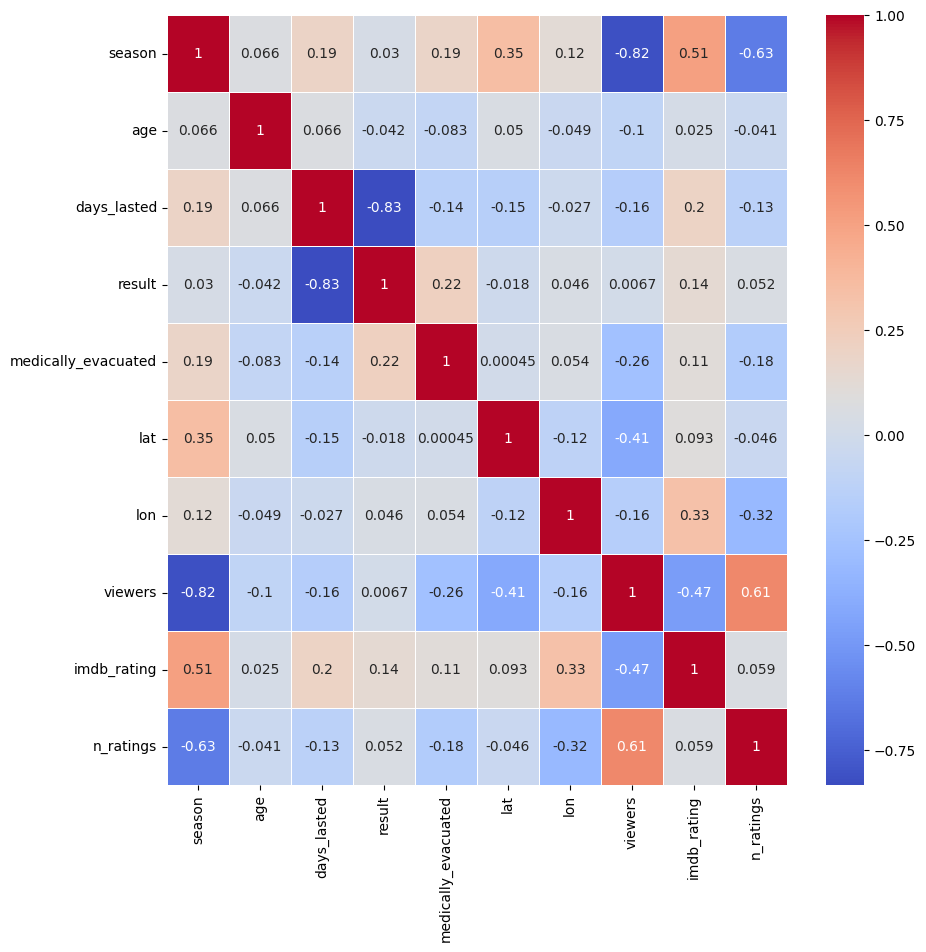

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(numeric_only=True), annot = True,cmap="coolwarm",linewidths=0.5, ax = ax)

**Inference:**
This correlation heatmap suggests only a few moderate linear relationships among the numeric variables, most correlations are weak.

* Season seems moderately related to viewership metrics
* Days lasted is strongly related to the result variable
* Medical evacuation, latitude/longitude, and age show only very small correlations with outcome and viewership, suggesting no strong simple linear effect from these factors alone.

#### **Viewership vs Seasons**

<Figure size 600x400 with 0 Axes>

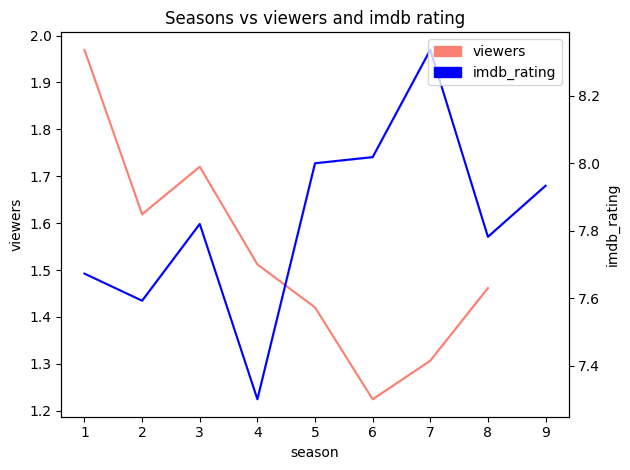

In [ ]:

plt.figure(figsize=(6,4))
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
sns.lineplot(
    data=df,
    x='season',
    y='viewers',
    color = 'salmon',
    ax = ax1
)
sns.lineplot(
    data=df,
    x='season',
    y='imdb_rating',
    color = 'blue',
    ax = ax2
)
plt.title('Seasons vs viewers and imdb rating')

sal_patch = mpatches.Patch(color='salmon', label='viewers')
blue_patch = mpatches.Patch(color='blue', label='imdb_rating')
plt.legend(loc = "upper right",handles=[sal_patch, blue_patch])
plt.tight_layout()
plt.show()


**Inference**: Viewership clearly peaks in Season 1 and then declines in later seasons, while IMDb ratings gradually improve or stay high across later seasons.
This suggests initial viewership was strongest at launch.

#### **Location effect on survivals days lasted and how  imdb rating were imapcted**

<Figure size 1000x500 with 0 Axes>

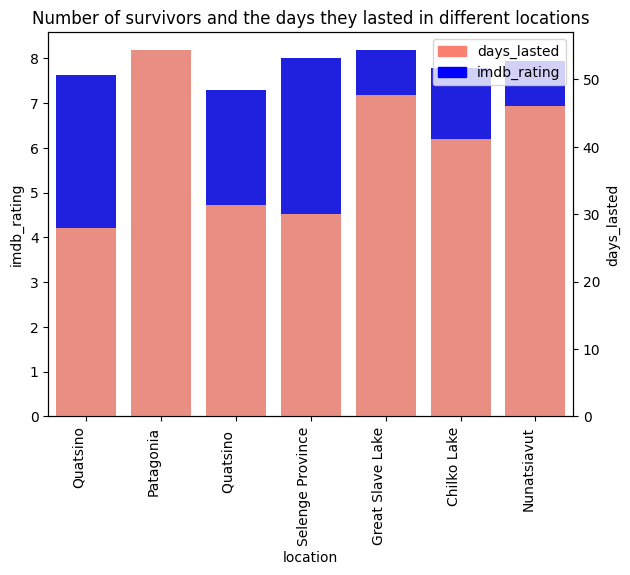

In [ ]:
plt.figure(figsize=(10,5))
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
sns.barplot(
    data=df,
    y='imdb_rating',
    x='location',
    color = 'blue',
    # legend = True, # Removed as it's not needed with manual patch legend
    ax = ax1,
    errorbar=None
)
sns.barplot(
     data=df,
     x='location',
     y='days_lasted',
     color = 'salmon',
     # legend=True, # Removed as it's not needed with manual patch legend
     ax = ax2,
     errorbar=None
 )

plt.title('Number of survivors and the days they lasted in different locations')
plt.tight_layout()
# plt.legend(loc= "upper left") # Removed this line due to UserWarning and redundancy
blu_patch = mpatches.Patch(color='blue', label='imdb_rating')
sal_patch = mpatches.Patch(color='salmon', label='days_lasted')
plt.legend(loc = "upper right",handles=[sal_patch, blu_patch])

# Fix the tick locations before setting labels to prevent UserWarning
ax1.set_xticks(ax1.get_xticks())
# Rotate x-axis labels on ax1
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right')
plt.show()

**Inference:** Survival durations vary noticeably by location, but higher IMDb ratings tend to align with locations where contestants did not necessarily last the longest.

This pattern suggests that tougher locations deliver engaging episodes that viewers rate highly, while easier environments do not get better audience ratings.

####  **Days lasted vs age**

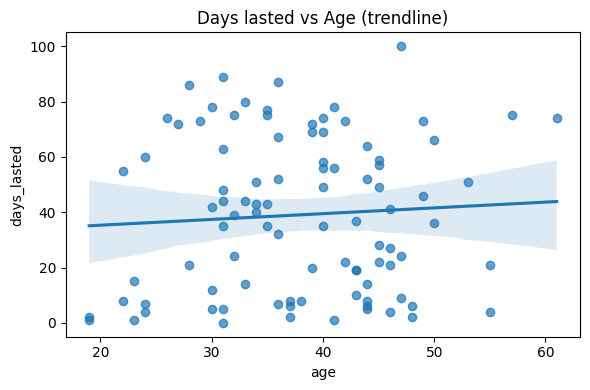

In [ ]:
plt.figure(figsize=(6,4))
sns.regplot(
    data=df,
    x='age',
    y='days_lasted',
    scatter_kws={'alpha':0.7}
)
plt.title('Days lasted vs Age (trendline)')
plt.tight_layout()
plt.show()


**Inference:**
The scatter plot shows a very weak trend between age and days lasted, with wide spread around the line.

Overall, age does not appear to have a strong impact on how long contestants survive.

#### **Days lasted by reason_category**

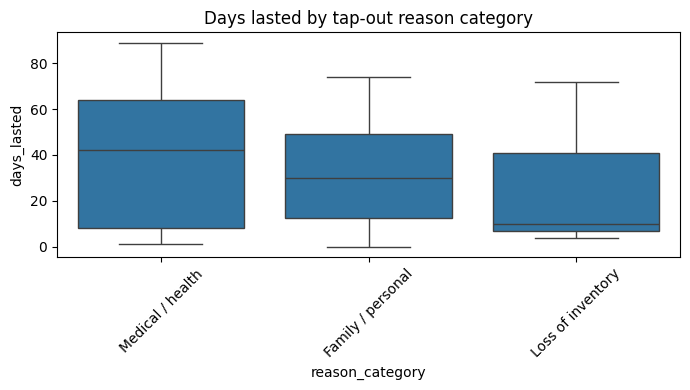

In [ ]:
plt.figure(figsize=(7,4))
sns.boxplot(
    data=df,
    x='reason_category',
    y='days_lasted'
)
plt.xticks(rotation=45)
plt.title('Days lasted by tap-out reason category')
plt.tight_layout()
plt.show()


**Inference:**
Contestants who tap out for medical or health reasons tend to leave earlier, compared with those who leave for family/personal reasons.
Participants exiting due to loss of inventory generally have the shortest stays.

<BarContainer object of 94 artists>

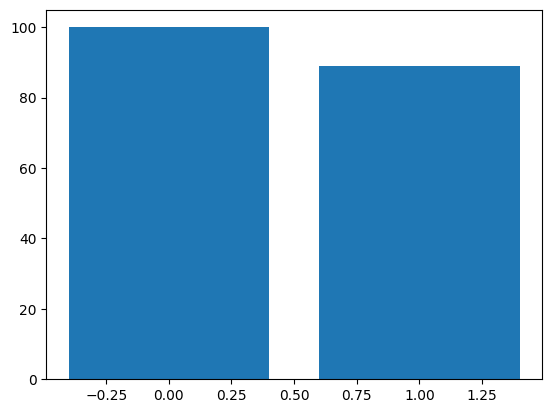

In [ ]:
df['medically_evacuated'] = df['medically_evacuated'].astype('category')
plt.bar(df['medically_evacuated'], df['days_lasted'])

**Inference:**
Contestants who are medically evacuated tend to stay slightly fewer days on average than those who are not, indicating health issues cut some runs short.

#### **Winner profile**

In [ ]:
df[df['result'] == 1]['age'].value_counts()

,count
age,
40,2
35,2
50,1
36,1
32,1
24,1
47,1
30,1


In [ ]:
df[df['result'] == 1]['gender'].value_counts()

,count
gender,
Male,10


In [ ]:
df[df['result'] == 1]['profession'].value_counts()

,count
profession,
Corrections Officer,1
Writer and Former Missionary,1
Boat builder,1
Freelance Writer,1
Adventure Videographer,1
Wilderness Skills Instructor,1
Construction,1
Hunting Guide,1
Professional Bowyer & Hunter,1


In [ ]:
df[df['result'] == 1]['country'].value_counts()

,count
country,
United States,7
Canada,3


**Inference:** The winner for all 9 seasons of "Alone" were United States males around the range of age from 30 to 40 with a variety of professional background from a writer to a construction worker.

### **Winner Profile items used for survival**

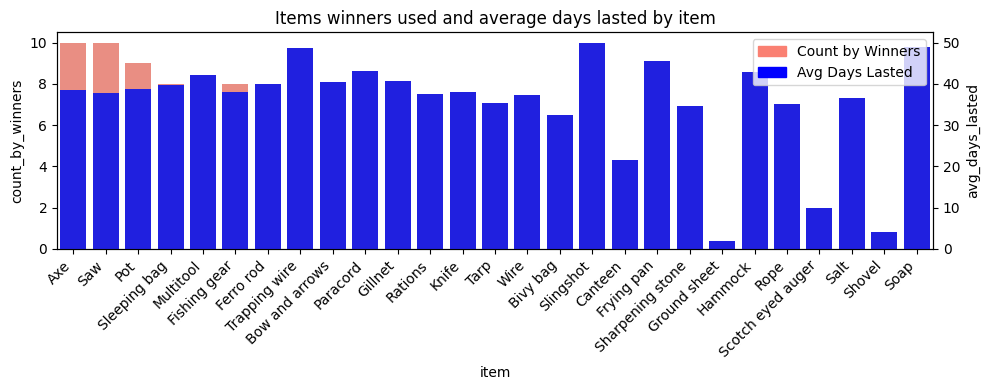

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,4))

df1 = df[df['result'] == 1]

# Data for winner items count
exploded_df1 = df1.explode('item')
winner_item_counts = exploded_df1['item'].value_counts().reset_index()
winner_item_counts.columns = ['item', 'count_by_winners']

# Data for average days lasted per item (across all participants)
exploded_df_all = df.explode('item')
avg_days_per_item = exploded_df_all.groupby('item')['days_lasted'].mean().reset_index()
avg_days_per_item.columns = ['item', 'avg_days_lasted']

# Merge the two dataframes to ensure consistent item order for plotting
# Use outer merge to include all items if one dataset has an item the other doesn't
plot_data = pd.merge(winner_item_counts, avg_days_per_item, on='item', how='outer').fillna(0) # Fill NaN if an item is not in one group

# Sort by count_by_winners for better visualization
plot_data = plot_data.sort_values(by='count_by_winners', ascending=False)

sns.barplot(
    data=plot_data,
    x='item',
    y='count_by_winners',
    color='salmon',
    ax=ax1,
    errorbar=None
)

ax2 = ax1.twinx()

sns.barplot(
    data=plot_data,
    x='item',
    y='avg_days_lasted',
    color='blue',
    ax=ax2,
    errorbar=None
)

plt.title('Items winners used and average days lasted by item')

for label in ax1.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

plt.tight_layout()

sal_patch = mpatches.Patch(color='salmon', label='Count by Winners')
blu_patch = mpatches.Patch(color='blue', label='Avg Days Lasted')
plt.legend(handles=[sal_patch, blu_patch])

plt.show()

**Inference:** Items like bow and arrows, trapping wire, ground sheet, and knives are both frequently chosen by winners and associated with higher average survival days.
This suggests that effective shelter, hunting, and trapping tools are common in successful players and may contribute to longer stays in the competition.

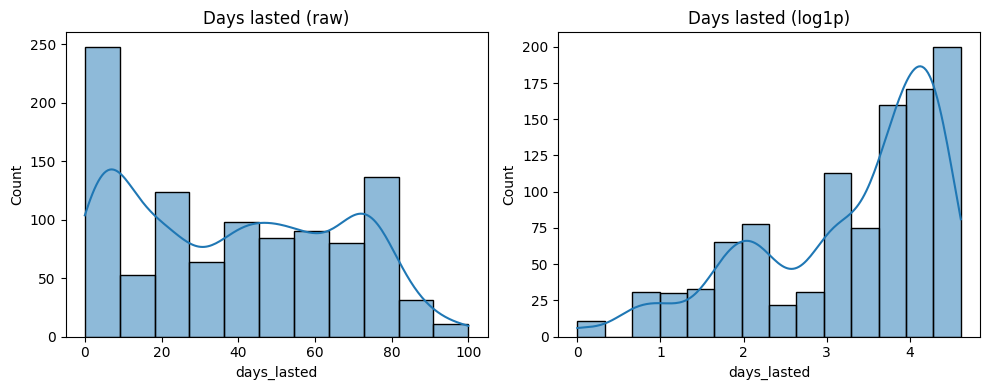

In [ ]:

import scipy.stats as stats

numeric_cols = ['days_lasted', 'age', 'viewers', 'imdb_rating', 'n_ratings']
eda_num = (
    sur.merge(epi[['season','episode','viewers','imdb_rating','n_ratings']],
              on='season', how='left')
)

eda_num[numeric_cols].describe()

# Skewness table
skew_vals = eda_num[numeric_cols].skew()
skew_vals.to_frame('skewness').sort_values('skewness', ascending=False)
# Example: distribution + log-transform for days_lasted
fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.histplot(eda_num['days_lasted'], kde=True, ax=axes[0])
axes[0].set_title('Days lasted (raw)')

sns.histplot(np.log1p(eda_num['days_lasted']), kde=True, ax=axes[1])
axes[1].set_title('Days lasted (log1p)')

plt.tight_layout()
plt.show()



**Inference:**



**Days_lasted is strongly right‑skewed.**

Most contestants last relatively few days, and a small number last very long, which is why the raw histogram piles up on the left and stretches out to the right.

**A log transform makes the distribution more balanced.**

After applying log, the histogram looks more symmetric, which is useful for methods that assume roughly normal features (e.g., distance based clustering on numeric variables).



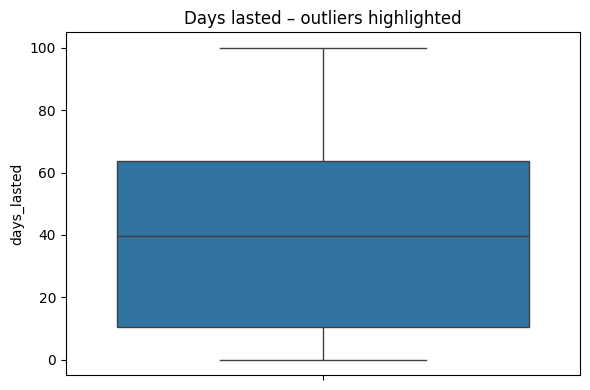

In [ ]:
from scipy.stats import zscore
sur['days_lasted_z'] = zscore(sur['days_lasted'])

# Flag extreme outliers (e.g., |z| > 2.5)
outliers = sur[sur['days_lasted_z'].abs() > 2.5][
    ['season', 'name', 'days_lasted', 'days_lasted_z', 'reason_category']
]
outliers.head()
plt.figure(figsize=(6,4))
sns.boxplot(data=sur, y='days_lasted')
plt.title('Days lasted – outliers highlighted')
plt.tight_layout()
plt.show()



**Inference:** These outliers are the people who lasted dramatically longer than the median, reinforcing that survival time has a long right tail. The extreme cases are exactly the “champions".This justifies treating winners and top finishers as a distinct group when you do clustering or segmentation later.



**Average survival days by age band and tap‑out reason**

In [ ]:
# Create age bands
bins = [18, 30, 40, 50, 65]
labels = ['18–29','30–39','40–49','50–65']
sur['age_band'] = pd.cut(sur['age'], bins=bins, labels=labels, right=False)

age_reason = (
    sur.groupby(['age_band','reason_category'])['days_lasted']
       .agg(['count','mean','median'])
       .reset_index()
)
age_reason


/tmp/ipython-input-4261077927.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sur.groupby(['age_band','reason_category'])['days_lasted']


,age_band,reason_category,count,mean,median
0,18–29,Family / personal,6,39.833333,38.0
1,18–29,Loss of inventory,1,4.000000,4.0
2,18–29,Medical / health,6,29.333333,7.5
3,30–39,Family / personal,12,27.333333,33.5
4,30–39,Loss of inventory,1,72.000000,72.0
5,30–39,Medical / health,18,38.833333,42.5
6,40–49,Family / personal,15,26.933333,22.0
7,40–49,Loss of inventory,1,10.000000,10.0
8,40–49,Medical / health,18,40.500000,41.5
9,50–65,Family / personal,3,43.666667,36.0


**Mean days_lasted by age band and tap‑out reason**

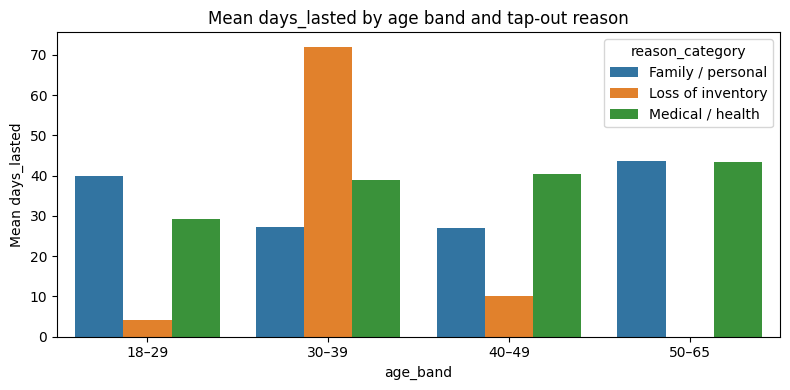

In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(
    data=age_reason,
    x='age_band',
    y='mean',
    hue='reason_category'
)
plt.title('Mean days_lasted by age band and tap‑out reason')
plt.ylabel('Mean days_lasted')
plt.tight_layout()
plt.show()


**Inference:**
Across most age bands, contestants who leave for family or personal reasons tend to have higher mean survival days than those who exit due to medical issues or inventory loss.

The 30–39 group that taps out for loss of inventory stands out with especially long average stays, suggesting that some highly resilient players only leave when gear failure, not physical or emotional limits, forces an exit.

**Episodes that over‑ and under‑perform relative to their season’s average viewership**

In [ ]:
# Episode performance vs season average
epi_perf = epi.copy()
epi_perf['season_mean_viewers'] = epi_perf.groupby('season')['viewers'].transform('mean')
epi_perf['viewers_diff'] = epi_perf['viewers'] - epi_perf['season_mean_viewers']

# Top over‑performers and under‑performers
top_eps = epi_perf.sort_values('viewers_diff', ascending=False).head(5)[
    ['season','episode','title','viewers','season_mean_viewers','viewers_diff']
]
bottom_eps = epi_perf.sort_values('viewers_diff').head(5)[
    ['season','episode','title','viewers','season_mean_viewers','viewers_diff']
]
top_eps, bottom_eps


(    season  episode               title  viewers  season_mean_viewers  \
 10       1       11             Triumph    2.375             1.969700   
 33       3       10              Day 87    2.117             1.720400   
 82       8        7          Surrounded    1.705             1.461750   
 50       5        7  Desperate Measures    1.661             1.420400   
 74       7       10    Pins and Needles    1.546             1.306818   
 
     viewers_diff  
 10      0.405300  
 33      0.396600  
 82      0.243250  
 50      0.240600  
 74      0.239182  ,
     season  episode             title  viewers  season_mean_viewers  \
 24       3        1        A New Land    1.245             1.720400   
 0        1        1  And So It Begins    1.582             1.969700   
 1        1        2   Of Wolf and Man    1.697             1.969700   
 62       6        9    The Ice Cometh    0.989             1.224545   
 47       5        4  Mongolia's Wrath    1.188             1.420400   
 

**Episode viewers vs season average**

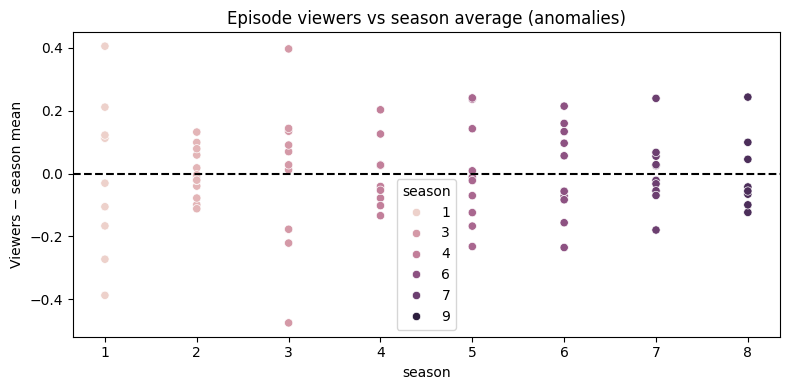

In [ ]:
plt.figure(figsize=(8,4))
sns.scatterplot(
    data=epi_perf,
    x='season',
    y='viewers_diff',
    hue='season'
)
plt.axhline(0, color='black', linestyle='--')
plt.title('Episode viewers vs season average (anomalies)')
plt.ylabel('Viewers − season mean')
plt.tight_layout()
plt.show()


**Inference:** Each point shows how much an episode’s viewers differ from its own season’s average. This highlights over‑performing and under‑performing episodes within each season, helping you identify which episodes attracted unusually high or low audiences given their season baseline.

**Reference**

1. [wiki page](https://en.wikipedia.org/wiki/Alone_(TV_series)
2. [stat.cmu](https://www.stat.cmu.edu/capstoneresearch/fall2023/315files_f23/team10.html)
3. [stackoverflow..com](https://stackoverflow.com/questions)

**Generative AI Disclosure**

* ChatGPT was used selectively for writing and coding assistance, under full team validation and oversight.
* Code standardization: Helped align style and reduce warnings; all notebooks were re‑run end‑to‑end by the team to verify correctness.
* Writing and documentation: Assisted with grammar and wording; every numeric statement was cross‑checked against our own tables and figures, and text was kept only when it matched our results.
* Visualization refinement: Suggested clearer axis labels, legends, and color choices; all plots were regenerated directly from our data and reviewed by the team.
* Generative AI was not used to derive conclusions or interpret results; final interpretations and decisions are entirely our own.


**Links to ChatGPT Conversation:**

1. [Chat GPT LINK 1](https://chatgpt.com/share/697aae22-eeb4-8007-9d80-b578426a8647)

2. [Chat GPT LINK 2](https://chatgpt.com/share/697aae5b-0ec8-8007-b51c-c8ba9aa58ce9)


3. [Chat GPT LINK 3](https://chatgpt.com/share/697aa979-3acc-8010-a5da-63ce53e543f5-)

4. [Chat GPT LINK 4](https://chatgpt.com/share/697abf0f-cdf4-8007-bbe3-d32e1eeeed4a)

# **Phase 2: Early Analysis & Insights**
## Purnima Khemka

## **Domain Question**



**Q2. How do season level survival patterns differ between Season 1 and other seasons, and do these differences line up with changes in viewership and ratings in a way that could explain the decline in audience over time?**

Does season level profiling and grouping based on survival and audience metrics, links changes in game design to loss of viewers over time, and may also guide decisions about which Season 1 elements to bring back.


## **Preprocessing**
This ensures data types are correct for aggregation.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   version              94 non-null     object  
 1   season               94 non-null     int64   
 2   id                   94 non-null     object  
 3   name                 94 non-null     object  
 4   age                  94 non-null     int64   
 5   gender               94 non-null     object  
 6   profession           94 non-null     object  
 7   city                 94 non-null     object  
 8   state                93 non-null     object  
 9   country              94 non-null     object  
 10  days_lasted          94 non-null     int64   
 11  result               94 non-null     int64   
 12  medically_evacuated  94 non-null     category
 13  reason_category      84 non-null     object  
 14  location             94 non-null     object  
 15  lat                  94 n

In [ ]:
df['medically_evacuated'] = df['medically_evacuated'].astype(int)

## **Season-level Dataframe**
This will give one row per season.

In [ ]:
season_df = (
    df.groupby(['version', 'season'], as_index=False)
    .agg(
        # Survival difficulty
        mean_days_lasted=('days_lasted', 'mean'),
        median_days_lasted=('days_lasted', 'median'),
        max_days_lasted=('days_lasted', 'max'),
        medical_evac_rate=('medically_evacuated', 'mean'),

        # Audience engagement
        avg_viewers=('viewers', 'mean'),
        avg_imdb_rating=('imdb_rating', 'mean'),
        avg_n_ratings=('n_ratings', 'mean'),

        # Metadata
        lat=('lat', 'first'),
        lon=('lon', 'first')))

season_df['is_season_1'] = (season_df['season'] == 1).astype(int)

season_df

,version,season,mean_days_lasted,median_days_lasted,max_days_lasted,medical_evac_rate,avg_viewers,avg_imdb_rating,avg_n_ratings,lat,lon,is_season_1
0,US,1,21.600000,7.0,56,0.000000,1.969700,7.672727,101.545455,50.724440,-127.498056,1
1,US,2,34.400000,28.0,66,0.100000,1.619077,7.592308,66.769231,50.724440,-127.498056,0
2,US,3,54.300000,61.5,87,0.300000,1.720400,7.820000,61.200000,-41.000000,-68.000000,0
3,US,4,31.428571,14.0,75,0.285714,1.512200,7.300000,47.900000,50.724440,-127.498056,0
4,US,5,30.100000,31.5,60,0.300000,1.420400,8.000000,51.400000,49.750000,106.500000,0
5,US,6,45.400000,50.0,77,0.500000,1.224545,8.018182,58.909091,61.500278,-114.001111,0
6,US,7,49.900000,44.0,100,0.300000,1.306818,8.336364,73.909091,61.500278,-114.001111,0
7,US,8,41.200000,30.5,74,0.300000,1.461750,7.781818,57.727273,51.266667,-124.050000,0
8,US,9,46.100000,44.5,78,0.300000,NaN,7.933333,27.666667,59.660000,-64.273611,0


## **1. Correlation Matrix of Survival Difficulty and Audience Metrics**

This summarizes the pairwise relationships between season-level survival difficulty metrics and audience engagement measures.

In [ ]:
# Correlation matrix
corr_mat = season_df[['mean_days_lasted', 'medical_evac_rate', 'avg_viewers', 'avg_imdb_rating']].corr()
corr_mat

,mean_days_lasted,medical_evac_rate,avg_viewers,avg_imdb_rating
mean_days_lasted,1.000000,0.635954,-0.464522,0.538320
medical_evac_rate,0.635954,1.000000,-0.841256,0.418751
avg_viewers,-0.464522,-0.841256,1.000000,-0.515433
avg_imdb_rating,0.538320,0.418751,-0.515433,1.000000


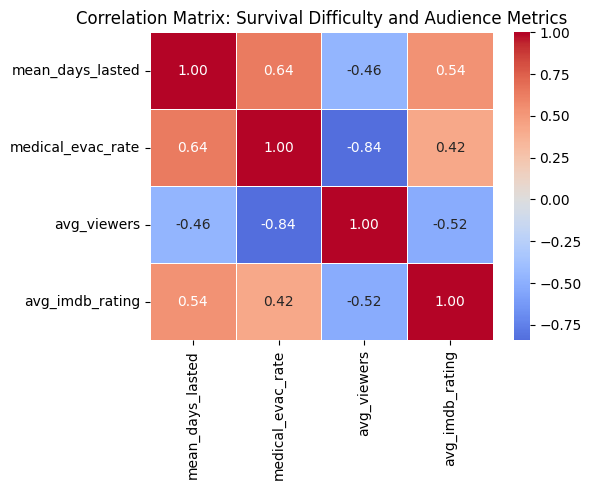

In [ ]:
# Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_mat,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5)

plt.title('Correlation Matrix: Survival Difficulty and Audience Metrics')
plt.tight_layout()
plt.show()

**Observation**

Mean survival duration and medical evacuation rate are strongly positively correlated (0.64), indicating that seasons with longer average stays also tend to have higher medical risk.

Both survival difficulty measures are negatively correlated with viewership, with medical evacuation rate showing a particularly strong negative relationship (−0.84).

IMDb ratings show a moderate positive correlation with survival difficulty but a negative correlation with viewership.

**Interpretation**

Increasing survival difficulty is associated with lower overall viewership, suggesting that harsher conditions alone do not attract larger audiences.

The positive relationship between survival difficulty and IMDb ratings indicates that remaining viewers may perceive later seasons as high quality, even as total audience size declines.

**Takeaway**

The positive relationship between survival difficulty and IMDb ratings suggests that while overall viewership declines, the remaining audience perceives later seasons as high quality, indicating a shift toward a smaller but more engaged viewer base.

## **2. Season-level Survival Difficulty**

This helps us understand how survival difficulty varies across seasons and whether Season 1 differs from later seasons in terms of survival duration and medical risk.

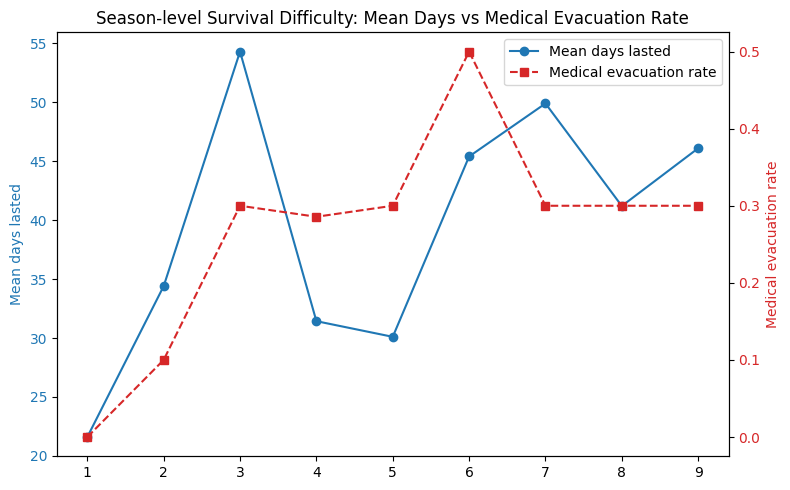

In [ ]:
season_plot = season_df.sort_values('season').copy()

fig, ax1 = plt.subplots(figsize=(8,5))
ax2 = ax1.twinx()

# Mean days lasted (left axis)
ax1.plot(
    season_plot['season'],
    season_plot['mean_days_lasted'],
    marker='o',
    color='tab:blue',
    label='Mean days lasted')

ax1.set_ylabel('Mean days lasted', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Medical evacuation rate (right axis)
ax2.plot(
    season_plot['season'],
    season_plot['medical_evac_rate'],
    marker='s',
    linestyle='--',
    color='tab:red',
    label='Medical evacuation rate')

ax2.set_ylabel('Medical evacuation rate', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Season-level Survival Difficulty: Mean Days vs Medical Evacuation Rate')
plt.xlabel('Season')
plt.tight_layout()
plt.show()

**Observations**

Mean days lasted generally increase after Season 1 but fluctuate across later seasons.

Medical evacuation rates rise in later seasons, with a noticeable peak around Season 6.

There is no consistent inverse or direct relationship between mean days lasted and medical evacuation rate across seasons.

**Interpretations**

Survival conditions become more demanding in later seasons.

However, increases in survival difficulty are not consistent across seasons and do not move in a uniform direction.

Changes in survival difficulty alone do not show a clear pattern that aligns with the observed decline in viewership over time.

**Takeaway**

While survival difficulty increases in later seasons, these changes do not follow a consistent pattern that explains declining audience engagement, indicating that factors beyond survival structure likely drive the loss of viewers after Season 1.

## **Feature Preparation for Multivariate Analysis - Scaling and Transformation**
This prepares season-level features for distance-based unsupervised methods, like PCA and Clustering.

In [ ]:
features = [
    'mean_days_lasted',
    'median_days_lasted',
    'max_days_lasted',
    'medical_evac_rate',
    'avg_viewers',
    'avg_imdb_rating',
    'avg_n_ratings']

#Checking for missing values
season_df[features].isna().sum().sort_values(ascending=False)

,0
avg_viewers,1
median_days_lasted,0
mean_days_lasted,0
max_days_lasted,0
medical_evac_rate,0
avg_imdb_rating,0
avg_n_ratings,0


In [ ]:
#Identifying seasons with missing viewership data
season_df.loc[season_df['avg_viewers'].isna(), ['season', 'avg_viewers', 'avg_imdb_rating', 'avg_n_ratings']]

,season,avg_viewers,avg_imdb_rating,avg_n_ratings
8,9,NaN,7.933333,27.666667


In [ ]:
X = season_df[features].copy()

# Log transforms to reduce right skew
X['avg_viewers'] = np.log1p(X['avg_viewers'])
X['avg_n_ratings'] = np.log1p(X['avg_n_ratings'])

# Median imputation for Season 9 missing viewers
X['avg_viewers'] = X['avg_viewers'].fillna(X['avg_viewers'].median())

# Feature standardization for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## **3. Principal Component Analysis (PCA) of Season-level Features**

This helps us check whether Season 1 is different from later seasons when survival and audience metrics are considered together, and whether differences in survival structure help explain the decline in viewership over time.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
PC = pca.fit_transform(X_scaled)

season_df['PC1'] = PC[:, 0]
season_df['PC2'] = PC[:, 1]

pca.explained_variance_ratio_

array([0.60058397, 0.16696137])

**NOTE**

The first principal component (PC1) explains about 60% of the total variation in season-level survival and audience metrics, while the second component (PC2) explains about 17%. Together, PC1 and PC2 account for approximately 77% of the overall variation across seasons.

Most of the differences between seasons are explained by PC1, which reflects a contrast between survival intensity and audience popularity. PC2 adds additional information related to audience engagement quality but plays a smaller role. Given the small number of seasons and small remaining variance, including more components is unlikely to provide any meaningful insight and may instead introduce noise.

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=['PC1_loading', 'PC2_loading']
).sort_values('PC1_loading', ascending=False)

loadings

,PC1_loading,PC2_loading
mean_days_lasted,0.442868,0.197694
median_days_lasted,0.431196,0.166699
medical_evac_rate,0.413184,-0.330907
max_days_lasted,0.393005,0.294271
avg_imdb_rating,0.332898,0.370884
avg_n_ratings,-0.210811,0.713616
avg_viewers,-0.370812,0.300383


**Observation**

PC1 loads positively on survival duration metrics and medical evacuation rate, and negatively on viewership and rating counts.

PC2 loads strongly on IMDb rating counts and IMDb ratings, with weaker contribution from survival duration metrics, and a negative contribution from medical evacuation rate.

**Interpretation**

PC1 reflects a trade-off between survival intensity and audience popularity, distinguishing seasons characterized by longer and more physically demanding survival from those with broader audience reach.

PC2 represents variation in audience engagement quality, capturing differences in how actively and positively viewers respond to the show rather than differences in survival outcomes.

**Takeaway**

Survival difficulty and audience engagement emerge as distinct underlying dimensions, with audience response not directly aligned with increased survival intensity. This suggests that changes in survival difficulty alone are insufficient to explain patterns of audience engagement.

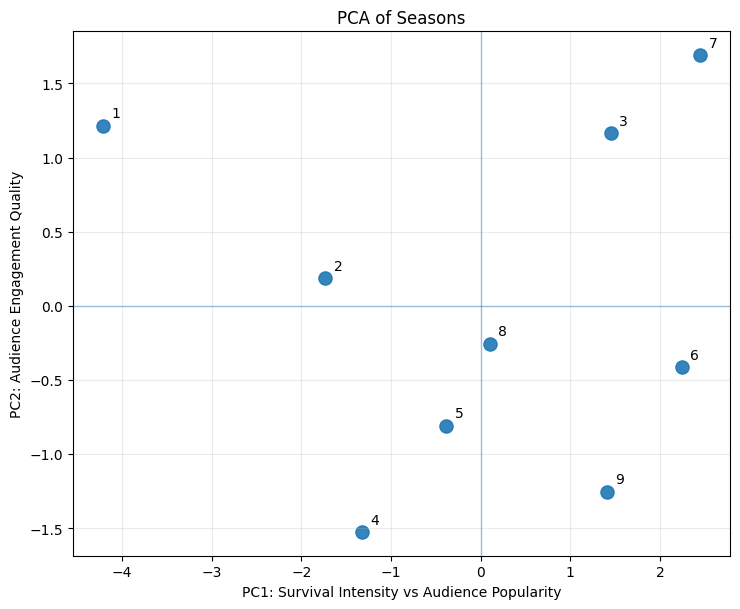

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(7.5, 6.2))

ax.scatter(season_df['PC1'], season_df['PC2'], s=90, alpha=0.9)

for _, r in season_df.iterrows():
    ax.annotate(
        str(r['season']),
        (r['PC1'], r['PC2']),
        textcoords="offset points",
        xytext=(6, 6),
        fontsize=10)

ax.axhline(0, linewidth=1, alpha=0.4)
ax.axvline(0, linewidth=1, alpha=0.4)

ax.set_xlabel('PC1: Survival Intensity vs Audience Popularity')
ax.set_ylabel('PC2: Audience Engagement Quality')
ax.set_title('PCA of Seasons')
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

**Observations**

Season 1 appears clearly separated from most later seasons along PC1, indicating substantially higher audience popularity relative to survival intensity.

Later seasons are more dispersed across PC2, showing variation in audience engagement quality despite similar survival structures.

Seasons do not follow a clear chronological pattern in PCA space.

**Interpretation**

Season 1 differs from later seasons mainly because of higher audience popularity, not greater survival difficulty.

Later seasons show differences in audience engagement quality rather than consistent changes in survival intensity.

Increased survival difficulty does not consistently correspond to higher viewership or stronger audience engagement.

**Takeaway**

Season 1 is distinct mainly due to higher popularity, while later seasons differ more in audience engagement than in survival difficulty, indicating that declining viewership is unlikely to be driven by survival design changes alone.

## **4. Hierarchical Clustering of Seasons**

Here, this is used as an exploratory validation to assess whether seasons form natural similarity groups when survival outcomes and audience engagement metrics are considered together.

While earlier analyses (survival difficulty trends and PCA) suggest continuous variation rather than distinct structural differences, clustering provides a complementary check by examining whether Season 1 or later seasons group distinctly based on overall similarity.

This helps evaluate whether changes in survival structure correspond to discrete season types that could plausibly explain declining audience engagement over time.

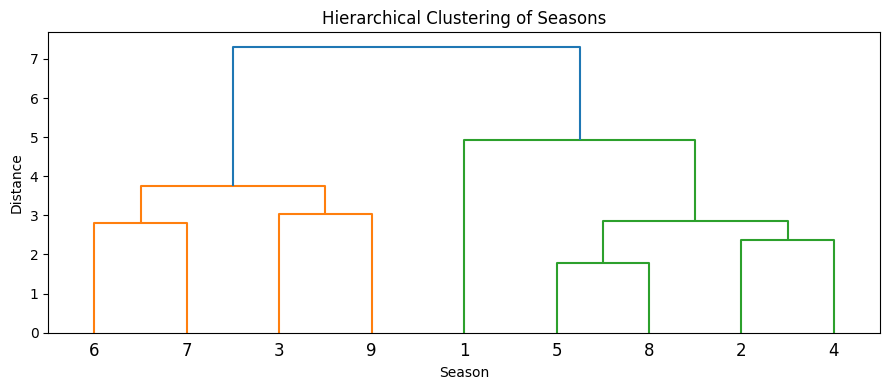

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(9,4))
dendrogram(Z, labels=season_df['season'].astype(str).values)
plt.title('Hierarchical Clustering of Seasons')
plt.xlabel('Season')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

**Observation**

The dendrogram reveals two broad clusters that merge only at a high distance, indicating two general season profiles: Cluster A: {6, 7, 3, 9} and Cluster B: {1, 5, 8, 2, 4}

Within these, there are multiple tight sub-clusters, indicating strong similarity: (6, 7), (3, 9), (5, 8), and (2, 4)

Season 1 is not a singleton, but it joins its cluster at a higher distance than the tight sub-pairs, suggesting partial distinctiveness.

**Interpretation**

Seasons do not separate cleanly by season order, indicating that survival and audience patterns do not evolve in a strictly chronological manner.

The presence of multiple tight sub-clusters suggests that some seasons share very similar survival and audience profiles, even if they are not adjacent in order.

Season 1 differs from later seasons, but not in an extreme or isolated way. Instead, it represents a distinct profile within a broader group, consistent with PCA results showing separation driven largely by audience metrics rather than survival structure alone.

**Takeaway**

Hierarchical clustering supports earlier findings by revealing multiple season similarity patterns without a chronological order-based split. It shows that while Season 1 is relatively distinct, it does not form a completely separate cluster, reinforcing the conclusion that changes in survival structure alone do not explain declining audience engagement over time.

## **Use of Generative AI Tools**

GenAI was used for conceptual understanding & reasoning, coding guidance, and text refinement.

•	All outputs were reviewed, revised, modified, and validated.

•	It was not used to interpret results or derive conclusions.

**ChatGPT Link**

https://chatgpt.com/share/698a7f23-b578-8005-97c1-184080a2ace6

https://chatgpt.com/share/698a84d4-4e90-8005-b0d2-41d55e8211e6

